In [1]:
import pandas as pd
import datetime
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import matplotlib.lines as line
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle


import seaborn as sns

import statsmodels as sm

from math import sqrt

from scipy import stats
from scipy.odr import *
from scipy.integrate import odeint
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
data=pd.read_csv('dpc-covid19-ita-andamento-nazionale.csv')
data['data'] = pd.to_datetime(data['data'])
data['data'] = data['data'].dt.strftime('%d/%m/%Y')
data.index=data['data']
data['totale_positivi']=data['totale_positivi']/60483973
data.drop('data',axis=1)

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
data,,,,,,,,,,,,,,,
24/02/2020,ITA,101,26,127,94,0.000004,0,221,1,7,229,4324,NaN,NaN,NaN
25/02/2020,ITA,114,35,150,162,0.000005,90,93,1,10,322,8623,NaN,NaN,NaN
26/02/2020,ITA,128,36,164,221,0.000006,74,78,3,12,400,9587,NaN,NaN,NaN
27/02/2020,ITA,248,56,304,284,0.000010,203,250,45,17,650,12014,NaN,NaN,NaN
28/02/2020,ITA,345,64,409,412,0.000014,233,238,46,21,888,15695,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11/05/2020,ITA,13539,999,14538,67950,0.001364,-836,744,106587,30739,219814,2606652,1702283.0,NaN,NaN
12/05/2020,ITA,12865,952,13817,67449,0.001344,-1222,1402,109039,30911,221216,2673655,1741903.0,dc-IT-0027,dc-EN-0027
13/05/2020,ITA,12172,893,13065,65392,0.001297,-2809,888,112541,31106,222104,2735628,1778952.0,NaN,NaN


In [3]:
data.index.to_series(index=range(data.index.size))

0     24/02/2020
1     25/02/2020
2     26/02/2020
3     27/02/2020
4     28/02/2020
         ...    
77    11/05/2020
78    12/05/2020
79    13/05/2020
80    14/05/2020
81    15/05/2020
Name: data, Length: 82, dtype: object

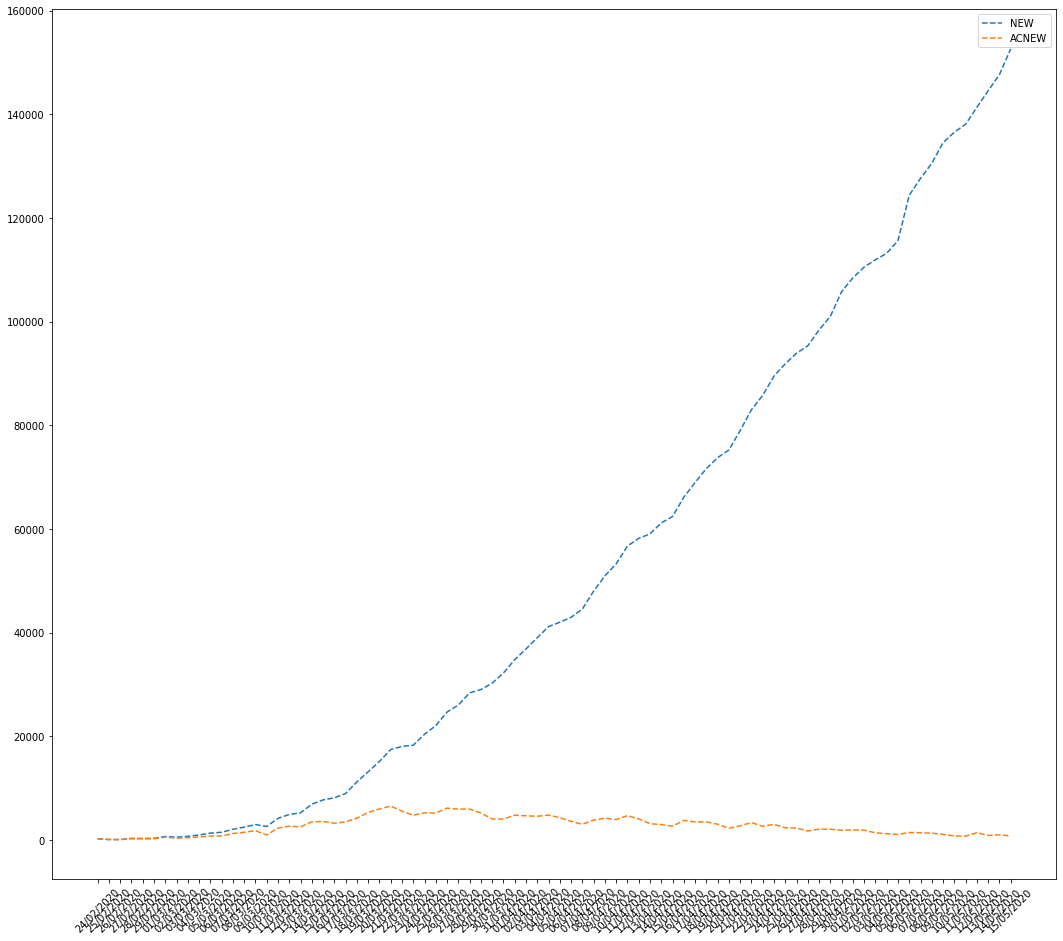

In [4]:
fig=plt.figure(figsize=(18,16))
new=fig.add_subplot(1,1,1)
#nooooooooooooooooo scemoooooo
new.plot(data.index,data['nuovi_positivi']+data['dimessi_guariti']+data['deceduti'],'--',label='NEW')
new.plot(data.index,data['nuovi_positivi'],'--',label='ACNEW')
plt.setp(new.xaxis.get_majorticklabels(), rotation=45)
new.legend()
#grw=fig.add_subplot(2,2,3)
#grw.plot(data.index,data['GRW'],'--',label='GRW')
#grw.plot(data.index,data['ACGRW'],'--',label='ACGRW')
#l = line.Line2D([13,25], [1,1])
#grw.add_line(l)
#grw.legend()

In [5]:
# time points
t=data.index.to_series(index=range(data.index.size))
t_fit=t[18:]
t_fitpre=t[:14]
t_fit=range(t_fit.size)
t_fitpre=range(t_fitpre.size)
t=range(t.size+30) 
tpre=range(t[-1]+18)
base = datetime.datetime.strptime('13/03/2020','%d/%m/%Y')
base2 = datetime.datetime.strptime('24/02/2020','%d/%m/%Y')
dlist =[base2 + datetime.timedelta(days=x) for x in range(200)]
mdate_list=[x for x in dlist if x<=datetime.datetime.strptime(data.index[-1],'%d/%m/%Y')]
date_list = [base + datetime.timedelta(days=x) for x in range(len(t))]
dpre_list=[x for x in dlist if x<date_list[-1]]
tpre

range(0, 129)

In [6]:
trans = 2.3 #rateo di trasmissione
recov = 0.6 #rateo di recovery
tmax = 60#numero di giorni fittizio
totpos=data['totale_positivi']
guar=data['dimessi_guariti']/60483973
#initial conditions DCM1103
sstart = 1-totpos['13/03/2020']
rstart = guar['13/03/2020']
istart = totpos['13/03/2020']
#initial conditions DCM0803
sstart8 = 1-totpos['24/02/2020']
rstart8 = guar['24/02/2020']
istart8 = totpos['24/02/2020']

                    
#fit base
def modelI(t,trans,recov):
# function that returns dy/dt
    def model(y,t):
        S=y[0]
        I=y[1]
        R=y[2]
        dS = -trans*S*I
        dI = trans*S*I-recov*I
        dR = recov*I
        return [dS,dI,dR]
    y0=[sstart,istart,rstart]
    # solve ODE
    y = odeint(model,y0,t)
    return y[:,1] 
                    
#fit basepre
def modelIpre(t,trans,recov):
# function that returns dy/dt
    def model(y,t):
        S=y[0]
        I=y[1]
        R=y[2]
        dS = -trans*S*I
        dI = trans*S*I-recov*I
        dR = recov*I
        return [dS,dI,dR]
    y0=[sstart8,istart8,rstart8]
    # solve ODE
    y = odeint(model,y0,t)
    return y[:,1] 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


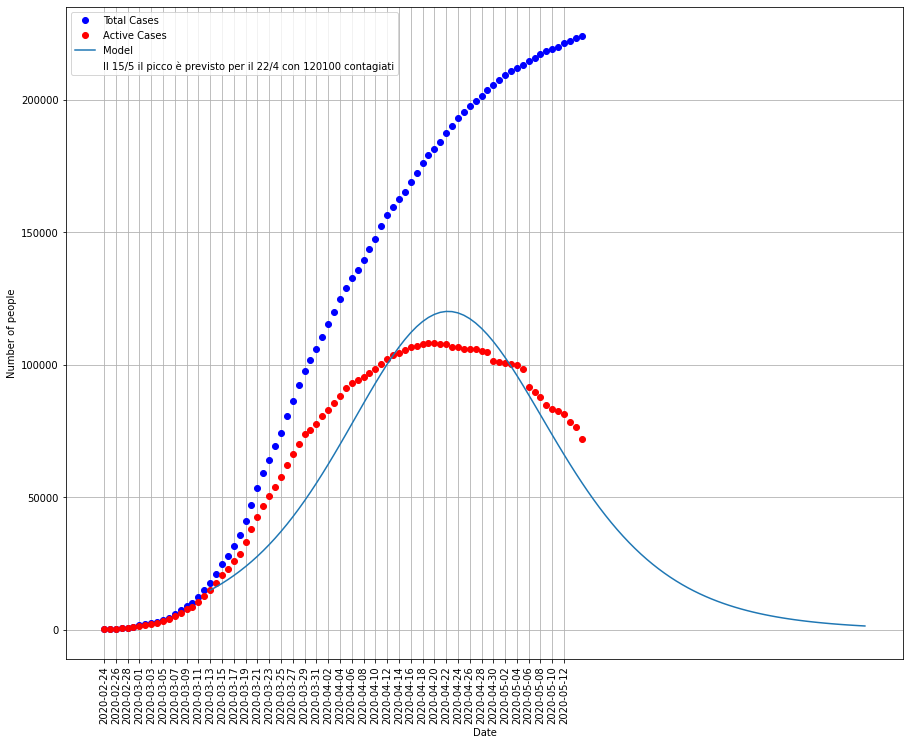

In [7]:
p,cov=curve_fit(modelI,t_fit,totpos['13/03/2020':],bounds=[[0,0],[+np.inf,+np.inf]])
trans,recov=p
curve_fit(modelIpre,t_fitpre,totpos['24/02/2020':'08/03/2020'],bounds=[[0,0],[+np.inf,+np.inf]])
fit=modelI(t,trans,recov)
fitpre=modelIpre(tpre,trans,recov)
fig2=plt.figure(figsize=(15,12))
tot=fig2.add_subplot(1,1,1)

tot.plot(mdate_list,
         data['totale_positivi']*60483973+data['dimessi_guariti']+data['deceduti'],
         'bo',
         label='Total Cases')
tot.plot(mdate_list,
         data['totale_positivi']*60483973,
         'ro',
         label='Active Cases')
tot.plot(date_list,
         fit*60483973,
         '-',
         label='Model')

s=fit*60483973
s=s.tolist()
ymax = max(s)
xpos = s.index(ymax)
xmax = date_list[xpos]

previsione = ("Il " +
             str(datetime.datetime.today().day) +"/"+ str(datetime.datetime.today().month)+
             " il picco è previsto per il "+
             str(xmax.day)+"/"+str(xmax.month) +
             " con "+
             str(round(ymax))+
             " contagiati")
tot.plot([], [], ' ', label=previsione)


tot.legend()
tot.set_xlabel('Date')
tot.set_ylabel('Number of people')
tot.set_xticks([base2 + datetime.timedelta(days=2*x) for x in range(40)])
plt.setp(tot.xaxis.get_majorticklabels(), rotation=90)
tot.grid(True)


fig2.savefig('contagi.eps',format='eps')
fig2.savefig('contagi.jpg',format='jpg')

In [8]:
p

array([1.36199034, 1.2821389 ])